<a href="https://colab.research.google.com/github/kili-technology/kili-python-sdk/blob/main/recipes/importing_pascalvoc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to import PascalVOC annotations into Kili

---



In this tutorial, we will demonstrate how to import PascalVOC annotations into Kili.

## Setup

Let's start by installing Kili and other packages

In [ ]:
%%capture
%pip install kili xmltodict

In [ ]:
import os
import tarfile

import xmltodict

from kili.client import Kili

## Download Pascal VOC format

The format and download for the full dataset is found [here](http://host.robots.ox.ac.uk/pascal/VOC/)

For this tutorial we will use a subset from the test set from 2012


In [ ]:
images_names = [
    "2007_000027",
    "2010_001121",
    "2010_001140",
    "2011_004772",
    "2012_003624",
    "2012_004328",
]
annos_folder = "Annotations"
images_folder = "JPEGImages"
images_extension = ".jpg"

In [ ]:
def check_create_dir(pth):
    if not os.path.exists(pth):
        os.mkdir(pth)


check_create_dir(images_folder)
check_create_dir(annos_folder)

In [ ]:
%%capture
for image_name in images_names:
    for fld, img_ext in zip([images_folder, annos_folder], [images_extension, ".xml"]):
        !curl https://raw.githubusercontent.com/kili-technology/kili-python-sdk/main/recipes/datasets/pascalVOC2012/valsubset/{fld}/{image_name}{img_ext} --output {fld}/{image_name}{img_ext}

## Reading xml files

In [ ]:
def xml_to_dict(xml_file: str):
    with open(xml_file, "r") as file:
        xml_data = file.read()
        xml_dict = xmltodict.parse(xml_data)
    return xml_dict

In [ ]:
images_annotations = []
for image_name in images_names:
    images_annotations.append(xml_to_dict(os.path.join(annos_folder, image_name + ".xml")))

## Create a Kili project

In [ ]:
if "KILI_API_KEY" in os.environ:
    KILI_API_KEY = os.environ["KILI_API_KEY"]
else:
    KILI_API_KEY = None

Please enter your API key: ··········


Initialize the Kili client

In [ ]:
kili = Kili(
    api_key=KILI_API_KEY,
)

In the dictionary below, we map the category ids to the category names from all annotation files:

In [ ]:
category_names = set()
for image_annos in images_annotations:
    pascalvoc_annos = image_annos["annotation"]["object"]
    if isinstance(pascalvoc_annos, dict):
        category_names.add(pascalvoc_annos["name"])
    else:
        for anno in image_annos["annotation"]["object"]:
            category_names.add(anno["name"])
category_names = list(category_names)

The `json_interface` variable contains the ontology of the project.


In [ ]:
json_interface = {"jobs": {}}

categories = {
    cat_name: {"children": [], "name": cat_name, "id": i}
    for i, cat_name in enumerate(category_names)
}

json_interface["jobs"]["OBJECT_DETECTION_JOB"] = {
    "content": {"categories": categories, "input": "radio"},
    "instruction": "BBox",
    "mlTask": "OBJECT_DETECTION",
    "required": 0,
    "tools": ["rectangle"],
    "isChild": False,
}

We can take a look at all the categories found with their respective ids

In [ ]:
for category in categories.values():
    print(category["id"], ":", category["name"])

0 : person

1 : car

2 : sofa

3 : cat


Create a Kili project using the json interface

In [ ]:
project = kili.create_project(
    title="[Kili SDK Notebook]: PascalVOC 2023",
    input_type="IMAGE",
    json_interface=json_interface,
)

# Importing images

Now that the project is imported, lets import the images

In [ ]:
content_array = []
external_id_array = []
for image_id, image_name in enumerate(images_names):
    content_array.append(os.path.join(images_folder, image_name + images_extension))
    external_id_array.append(str(image_name))

In [ ]:
%%capture
kili.append_many_to_dataset(
    project["id"], content_array=content_array, external_id_array=external_id_array
)

# Importing annotations to Kili

Below, we import some useful functions to convert annotations to Kili label format

In [ ]:
from typing import Dict, List

from kili.utils.labels.bbox import (
    bbox_points_to_normalized_vertices,
    point_to_normalized_point,
)

In [ ]:
def pascal_bbox_to_kili_normalized_vertices(
    pascal_bbox: Dict, img_width: int, img_height: int
) -> List[Dict]:
    x1, y1, x2, y2 = (
        pascal_bbox["xmin"],
        pascal_bbox["ymin"],
        pascal_bbox["xmax"],
        pascal_bbox["ymax"],
    )
    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
    kili_normalized_vertices = bbox_points_to_normalized_vertices(
        bottom_left={"x": x1, "y": y2},
        bottom_right={"x": x2, "y": y2},
        top_right={"x": x2, "y": y1},
        top_left={"x": x1, "y": y1},
        img_height=img_height,
        img_width=img_width,
        origin_location="top_left",
    )
    return kili_normalized_vertices

In [ ]:
json_response_array = []
for image_id, image_name in enumerate(images_names):
    image_annos = images_annotations[image_id]["annotation"]
    img_width, img_height = int(image_annos["size"]["width"]), int(image_annos["size"]["height"])

    json_resp = {}
    kili_bbox_annotations = []
    if isinstance(image_annos["object"], dict):
        image_annos["object"] = [image_annos["object"]]
    for ann in image_annos["object"]:
        kili_bbox_ann = {
            "children": {},
            "boundingPoly": [
                {
                    "normalizedVertices": pascal_bbox_to_kili_normalized_vertices(
                        ann["bndbox"], img_width=img_width, img_height=img_height
                    )
                }
            ],
            "categories": [{"name": ann["name"]}],
            "type": "rectangle",
        }
        kili_bbox_annotations.append(kili_bbox_ann)

    json_resp["OBJECT_DETECTION_JOB"] = {"annotations": kili_bbox_annotations}
    json_response_array.append(json_resp)

In [ ]:
%%capture
kili.append_labels(
    asset_external_id_array=external_id_array,
    project_id=project["id"],
    json_response_array=json_response_array,
)

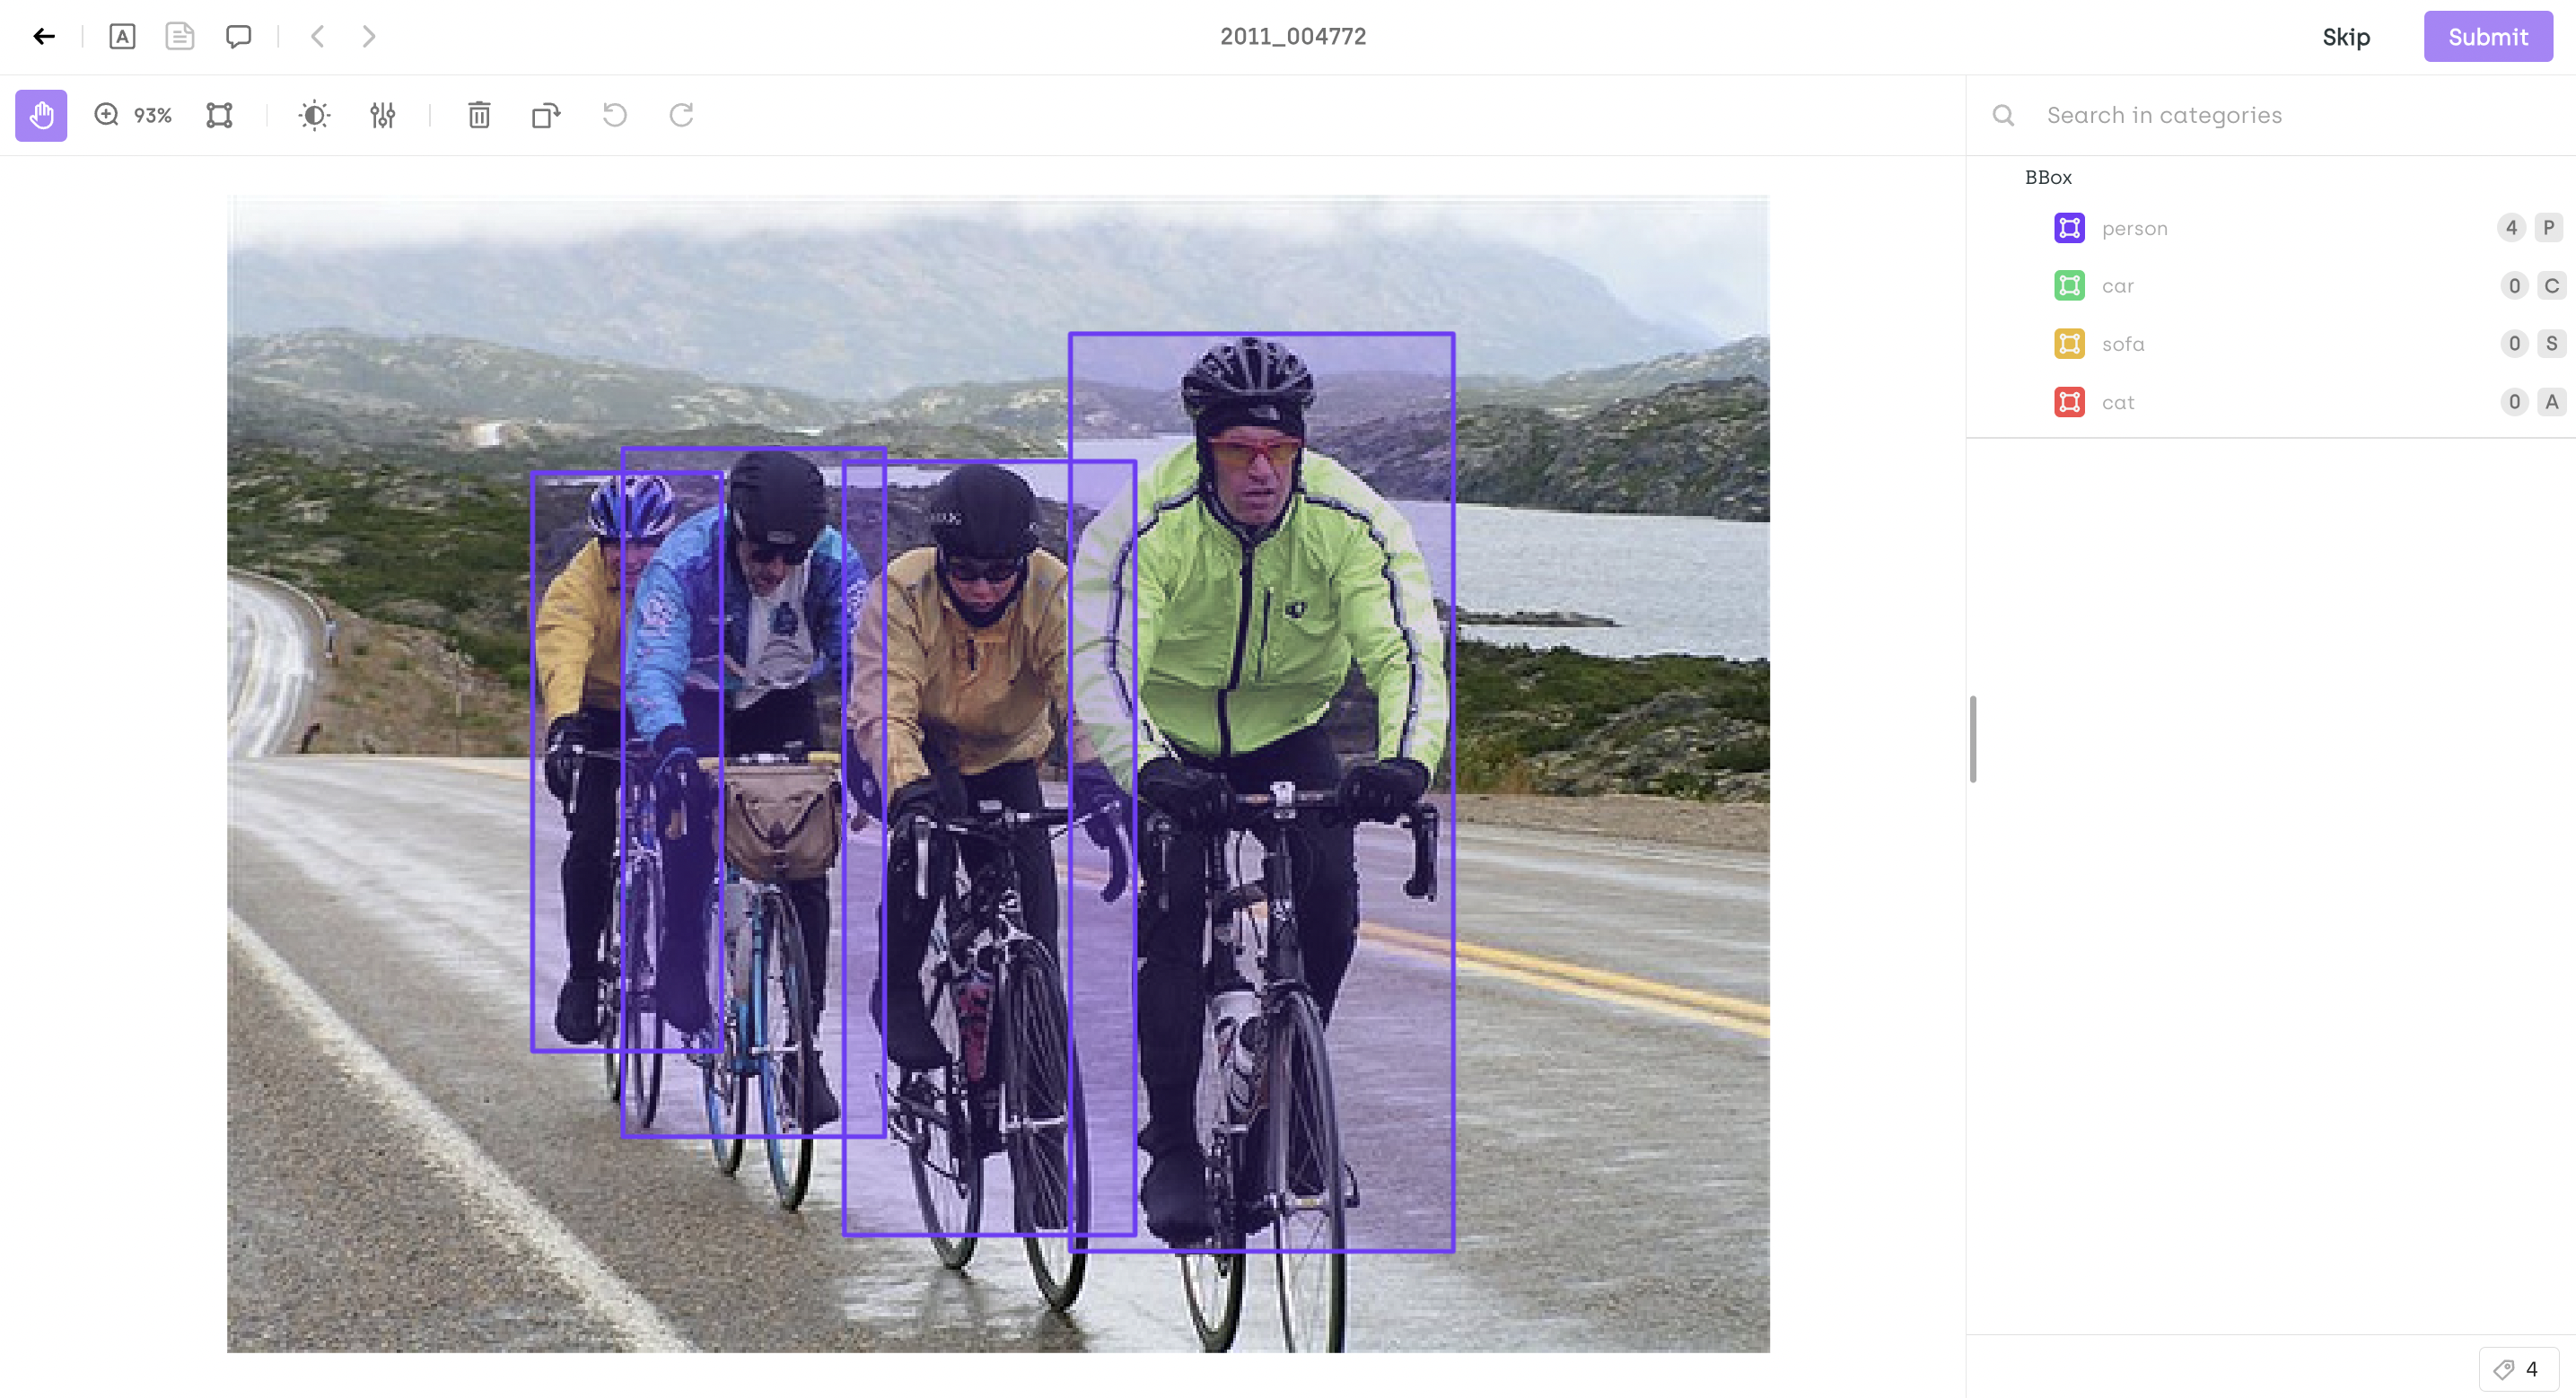In the Kili labeling interface, we can see the images and the annotations:


# Conclusion

In this tutorial, we have seen how to import Pascal VOC annotations into Kili.

You can now use Kili to refine and review your annotations, in order to train your machine learning models on high quality data.



# Clean up

Remove the project from your Kili projects



In [ ]:
%%capture
kili.delete_project(project_id=project["id"])